In [1]:
%matplotlib inline

# Tarea 5: Reducción de Dimensiones: caso de insuficiencia cardiaca 

Tecnológico de Costa Rica<br/>
Aprendizaje Automático <br/>


Cuaderno base para realizar la tarea 5, en la que se usará la reducción de dimensiones para visualizar la estructura de datos en espacios de muchas dimensiones.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder , StandardScaler

## Cargar datos de insuficiencia cardiaca

Los datos quedarán almacenados en X y las etiquetas en y

Los datos originales tienen varias columnas categóricas, que requieren ser 
codificadas one-hot para que tenga sentido.

Cargamos entonces primero los datos crudos, convirtiendo esas columnas a números,
y posteriormente 

In [3]:
archivo_csv = 'heart.csv' 

## Es necesario manejar manualmente la conversión de varias columnas categóricas
converters={}
for i in range(12):
    converters[i] = lambda x : float(x)
    
converters[1] =  lambda x : 1.0 if (x==b'F') else 0.0

# TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic
pain_types={b'TA':0.0,b'ATA':1.0,b'NAP':2.0,b'ASY':3.0}
converters[2] = lambda x : pain_types[x]

# RestingECG: resting electrocardiogram results 
#  Normal: Normal, 
#  ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV),
#  LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria
restingECG_types={b'Normal':0.0,b'ST':1.0,b'LVH':2.0}
converters[6] = lambda x : restingECG_types[x]

converters[8] =  lambda x : 1.0 if (x==b'Y') else 0.0

stslope_type = {b'Up':1.0,b'Flat':0.0,b'Down':-1.0}
converters[10] = lambda x : stslope_type[x]

# Carguemos los datos
data = np.genfromtxt(archivo_csv, delimiter=',',skip_header=1,converters=converters)

# Necesitamos recodificar dos columnas y luego armar la matriz de datos a pedazos
enc = OneHotEncoder()
cp=enc.fit_transform(data[:,2].reshape(-1,1)).toarray() # chest pain 
re=enc.fit_transform(data[:,6].reshape(-1,1)).toarray() # resting ECG

print("Datos completos en matriz {0} x {1}".format(data.shape[0],data.shape[1]))
data

with open(archivo_csv, 'r') as file:
    header = file.readline().strip().split(',')
    original_features = header[:-1]
    
    # Remove the empty string at the end if present
    if original_features[-1] == "":
        original_features = original_features[:1]

print(original_features)

Datos completos en matriz 918 x 12
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


In [4]:
# La última columna tiene las etiquetas
y=data[:,11].ravel()
print("Label shape:",y.shape)

# La columna col_grupos tiene los grupos
X=np.column_stack((data[:,0:2],cp,data[:,3:6],re,data[:,7:11]))
print("Data shape :",X.shape)
X

X[:,5:8]

Label shape: (918,)
Data shape : (918, 16)


array([[  0., 140., 289.],
       [  0., 160., 180.],
       [  0., 130., 283.],
       ...,
       [  1., 130., 131.],
       [  0., 130., 236.],
       [  0., 138., 175.]])

### Normalización de los datos

In [5]:
scaler = StandardScaler()
X_norm=X
X_norm[:,1:2] = scaler.fit_transform(X[:,1:2])  # Age, RestingBP
X_norm[:,5:8] = scaler.fit_transform(X[:,5:8])  # Cholesterol, MaxHR,

X_norm

array([[40.        , -0.51595242,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [49.        ,  1.93816322,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [37.        , -0.51595242,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [57.        , -0.51595242,  0.        , ...,  1.        ,
         1.2       ,  0.        ],
       [57.        ,  1.93816322,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [38.        , -0.51595242,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

### Métodos de reducción de dimensiones:

##### 2. Aplique PCA para proyectar los datos al subespacio de dos dimensiones con los dos componentes principales de mayor varianza.

In [6]:
from sklearn.decomposition import PCA

# PCA con 2 componentes principales
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_norm)




#### 3. Visualice los datos proyectados, utilizando las etiquetas en la segunda columna para identificar las dos clases.

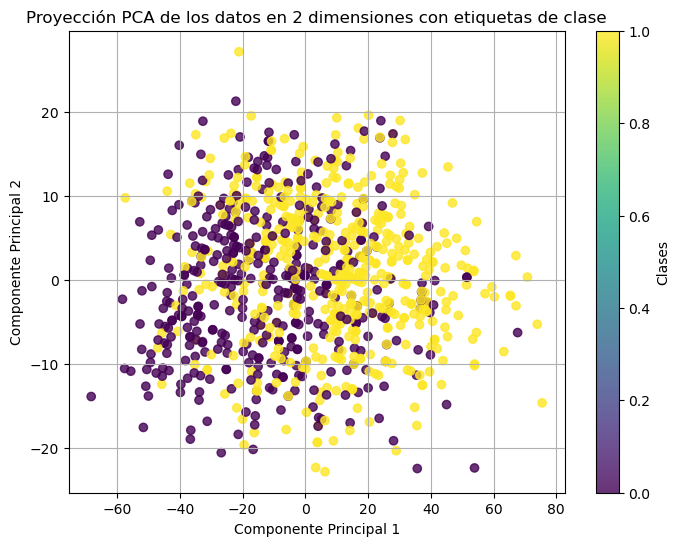

In [7]:
# Extraemos las etiquetas de clase de la segunda columna
clases = y
# Datos proyectados para cada clase
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clases, cmap='viridis', alpha=0.8)
plt.colorbar(label='Clases')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección PCA de los datos en 2 dimensiones con etiquetas de clase')
plt.grid(True)
plt.show()


###  Aglomeración

#### 4. Revise los primeros dos componentes principales (es decir, los dos eigenvectores con los mayores eigenvalores). ¿Es posible identificar si hay ejes en el espacio original más importantes que otros? ¿Es posible visualizar conglomerados en el subespacio bidimensional encontrado con PCA?

In [8]:
# Abrir el archivo y leer solo la primera línea (encabezado)
with open(archivo_csv, 'r') as file:
    header_line = file.readline().strip().split(',')  # Leer la primera línea, eliminar espacios en blanco y dividir por comas

# Convertir la primera línea a una lista de nombres de características
original_features = header_line

# Imprimir las características con mayor varianza en cada componente principal
num_feats_to_show = 5  
print("\nFeatures con mayor varianza en cada Componente Principal:")
for i, component in enumerate(pca.components_):
    sorted_index = np.argsort(np.abs(component))[::-1]
    print(f"Componente Principal {i+1}:")
    for j in range(min(num_feats_to_show, len(original_features))):
        index = sorted_index[j]
        if index < len(original_features):  # Verificar si el índice está dentro del rango válido
            print(f"- {original_features[index]}: {component[index]}")
    print()



Features con mayor varianza en cada Componente Principal:
Componente Principal 1:
- Age: 0.15787119155224083
- FastingBS: 0.013867971211921053
- MaxHR: -0.009173416273086165

Componente Principal 2:
- Age: 0.9864661388933629
- RestingECG: 0.026189011455040278
- Oldpeak: -0.01360350040719273



Age tiene el mayor coeficiente en este componente (0.15787119155224105), indicando que la edad es la característica más importante para PC1.
FastingBS y MaxHR tienen coeficientes mucho menores, sugiriendo que su contribución a PC1 es mínima en comparación con Age.

Age también tiene el coeficiente más alto en PC2 (0.9864661388933637), lo que sugiere que la edad es extremadamente importante para este componente.
RestingECG y Oldpeak tienen coeficientes significativamente menores, indicando que su contribución a PC2 es mínima.

#### 5. Repita lo anterior con UMAP, en su versión no supervisada (ver sitio de autores para instrucciones de cómo instalarlo). Experimente con los parámetros de UMAP para lograr una visible separación de las clases.

/home/david/micromamba/envs/t5/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


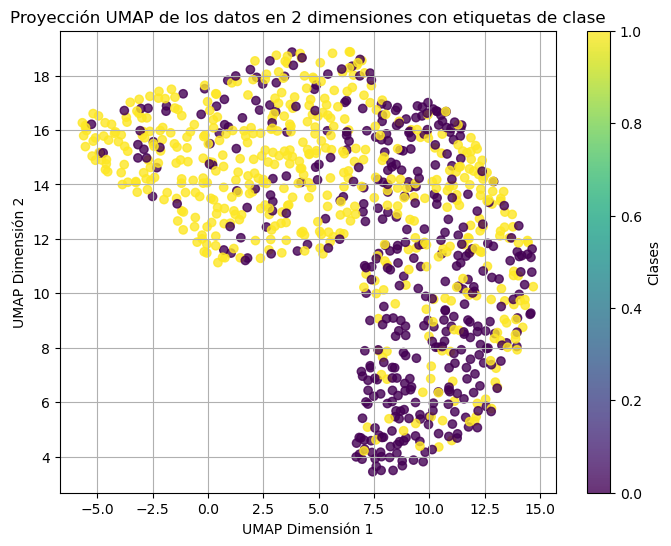

In [9]:
import umap

# Creamos una instancia de UMAP con 2 dimensiones
umap_model = umap.UMAP(n_neighbors=130, min_dist=1, random_state=42,n_epochs=500)

# Aplicamos UMAP a los datos normalizados
X_umap = umap_model.fit_transform(X_norm)

# Visualizamos los datos proyectados con colores para las clases
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clases, cmap='viridis', alpha=0.8)
plt.colorbar(label='Clases')
plt.xlabel('UMAP Dimensión 1')
plt.ylabel('UMAP Dimensión 2')
plt.title('Proyección UMAP de los datos en 2 dimensiones con etiquetas de clase')
plt.grid(True)
plt.show()


#### 6. Repita lo anterior con la versión supervisada de UMAP, para ayudar al método a encontrar estructuras más afines a un problema de clasificación como tal.

/home/david/micromamba/envs/t5/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


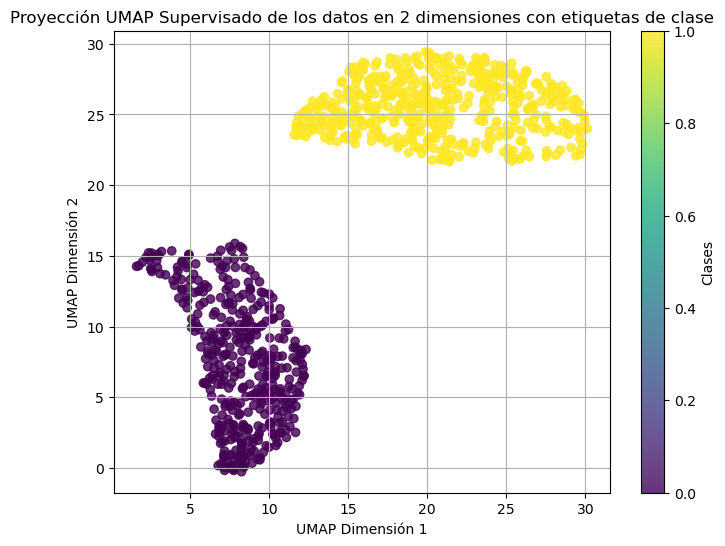

In [10]:
import umap

# Creamos una instancia de UMAP supervisada con 2 dimensiones
umap_model_supervised = umap.UMAP(n_neighbors=130, min_dist=1, random_state=42,n_epochs=500)

# Aplicamos UMAP supervisado a los datos normalizados y proporcionamos las etiquetas de clase
X_umap_supervised = umap_model_supervised.fit_transform(X_norm, y=clases)

# Visualizamos los datos proyectados con colores para las clases
plt.figure(figsize=(8, 6))
plt.scatter(X_umap_supervised[:, 0], X_umap_supervised[:, 1], c=clases, cmap='viridis', alpha=0.8)
plt.colorbar(label='Clases')
plt.xlabel('UMAP Dimensión 1')
plt.ylabel('UMAP Dimensión 2')
plt.title('Proyección UMAP Supervisado de los datos en 2 dimensiones con etiquetas de clase')
plt.grid(True)
plt.show()


#### 7. De los experimentos anteriores, analice si se pueden observar conglomerados aparentes, y qué número de ellos podría ser interesante evaluar.

La visualización de UMAP supervisado muestra que los puntos están distribuidos en un espacio bidimensional, con una separación aparente entre algunas áreas, clasificando en dos clases completamente distintas como se esperaría al ser supervisado.

#### 8. Utilice k-means para encontrar clústers en el espacio original de características, donde k es el número de clústers que, en el punto anterior, usted estima que hay.

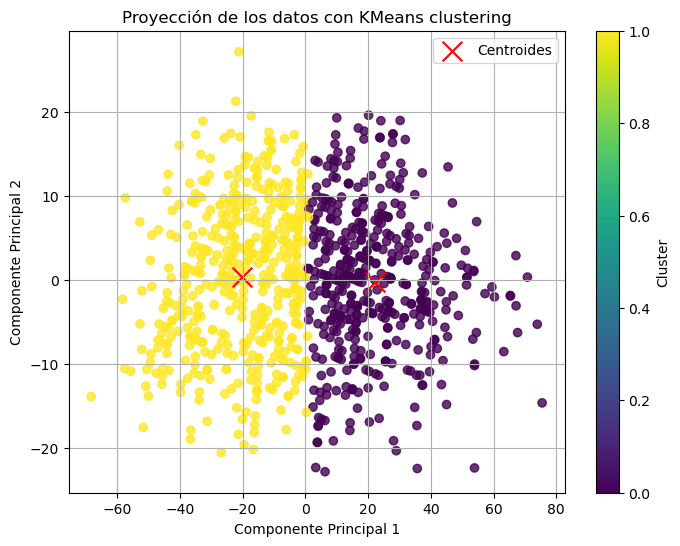

In [11]:
from sklearn.cluster import KMeans

# Creamos una instancia de KMeans para encontrar 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42,n_init='auto')

# Ajustamos KMeans a los datos proyectados
kmeans.fit(X_pca)
clusters = kmeans.labels_
# Obtener los centroides de K-means
centroids = kmeans.cluster_centers_
# Visualizamos los datos proyectados con colores según los clusters encontrados por KMeans
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='red', label='Centroides')
plt.colorbar(label='Cluster')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección de los datos con KMeans clustering')
plt.legend()
plt.grid(True)
plt.show()


#### 9. Visualice los clúster encontrados con la técnica de su preferencia. Es decir, repita los experimentos anteriores, pero en vez de usar la clase benigno/maligno o insuficiencia/saludable, use el número de clúster para determinar el color de los puntos. Se recomienda implementar la función de visualización en un archivo de Python (.py) que usted entonces importa en cada cuaderno que lo necesite. Esa función se usaría, entonces, ya sea con las etiquetas del conjunto de datos o con las etiquetas de los clúster encontrados. Así evita replicar el código y tener que dar mantenimiento a múltiples versiones.

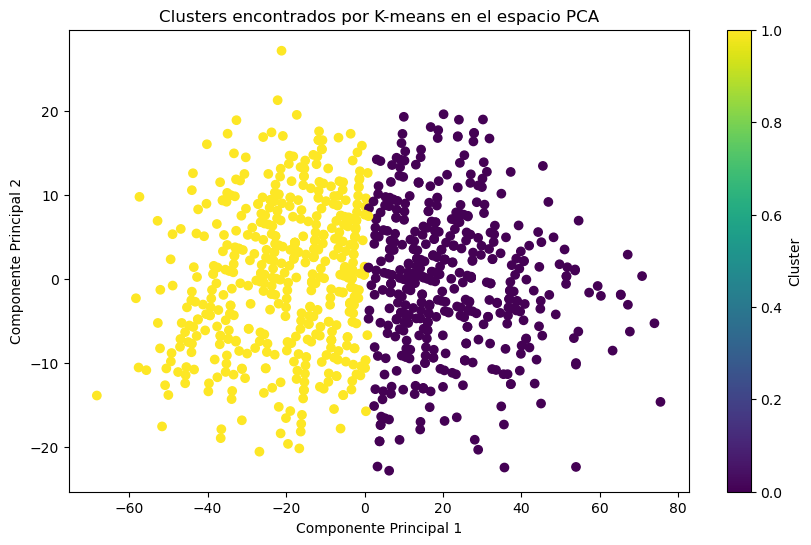

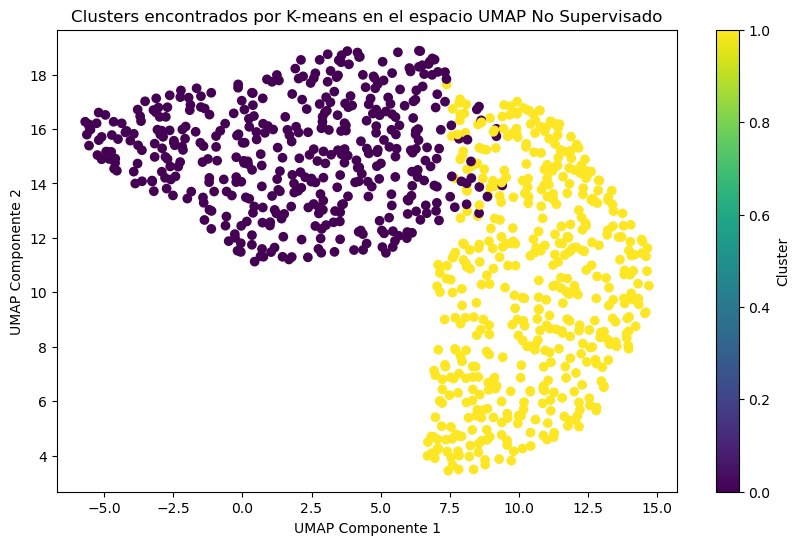

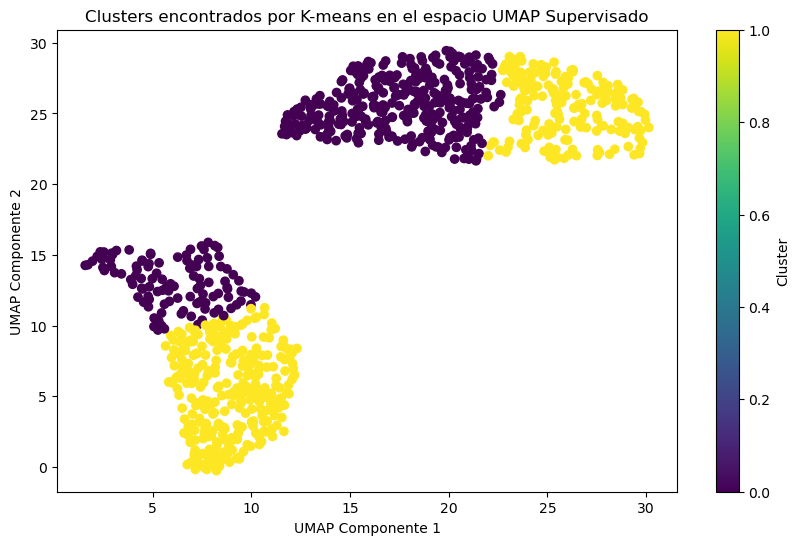

In [12]:
from visualization import plot_projection

plot_projection(X_pca, clusters, title='Clusters encontrados por K-means en el espacio PCA', xlabel='Componente Principal 1', ylabel='Componente Principal 2')


# Visualizar los clusters encontrados por K-means en el espacio UMAP no supervisado
plot_projection(X_umap, clusters, title='Clusters encontrados por K-means en el espacio UMAP No Supervisado', xlabel='UMAP Componente 1', ylabel='UMAP Componente 2')

# Visualizar los clusters encontrados por K-means en el espacio UMAP supervisado
plot_projection(X_umap_supervised, clusters, title='Clusters encontrados por K-means en el espacio UMAP Supervisado', xlabel='UMAP Componente 1', ylabel='UMAP Componente 2')

#### 10. Construcción de un Clasificador Generativo usando una Mezcla de Gaussianas

Como último punto, construya un clasificador generativo, utilizando una mezcla de gaussianas (GaussianMixture) para representar la distribución de densidad de cada una de las clases \(p(x|y)\). Ese método utiliza el algoritmo de esperanza-maximización para encontrar las distribuciones requeridas.

Con los modelos de cada clase, seleccione como clase ganadora aquella que conduce a la mayor probabilidad a posteriori \(p(y|x)\).

Debe utilizar algún método de selección de modelos (como por ejemplo el descrito aquí) para encontrar cuántas gaussianas aproximan bien la distribución de densidad probabilística de cada clase.

Debe partir sus datos en: datos de entrenamiento, de validación y de prueba, para esta parte, y utilizarlos como corresponde.

In [13]:

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

def select_best_gmm(X, n_components_range, cv_folds=5):
    """Selecciona el mejor GMM basado en BIC."""
    lowest_bic = np.infty
    best_gmm = None
    best_n_components = None
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        bic = gmm.bic(X)
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm
            best_n_components = n_components
    return best_gmm, best_n_components

# Rangos de componentes a probar
n_components_range = range(1, 11)

# Entrenar GMM para cada clase
gmms = {}
best_n_components_dict = {}
for label in np.unique(y_train):
    X_class = X_train[y_train == label]
    best_gmm, best_n_components = select_best_gmm(X_class, n_components_range)
    gmms[label] = best_gmm
    best_n_components_dict[label] = best_n_components
    print(f"Clase {label}: Mejor número de componentes = {best_n_components}")

# Validar el modelo usando el conjunto de validación
def predict_gmm(gmms, X):
    """Predice la clase basada en los modelos GMM."""
    log_probs = np.array([gmm.score_samples(X) for gmm in gmms.values()]).T
    return np.argmax(log_probs, axis=1)

Tamaño del conjunto de entrenamiento: (550, 16)
Tamaño del conjunto de validación: (184, 16)
Tamaño del conjunto de prueba: (184, 16)


Clase 0.0: Mejor número de componentes = 3
Clase 1.0: Mejor número de componentes = 5


Precisión en el conjunto de prueba: 0.8696


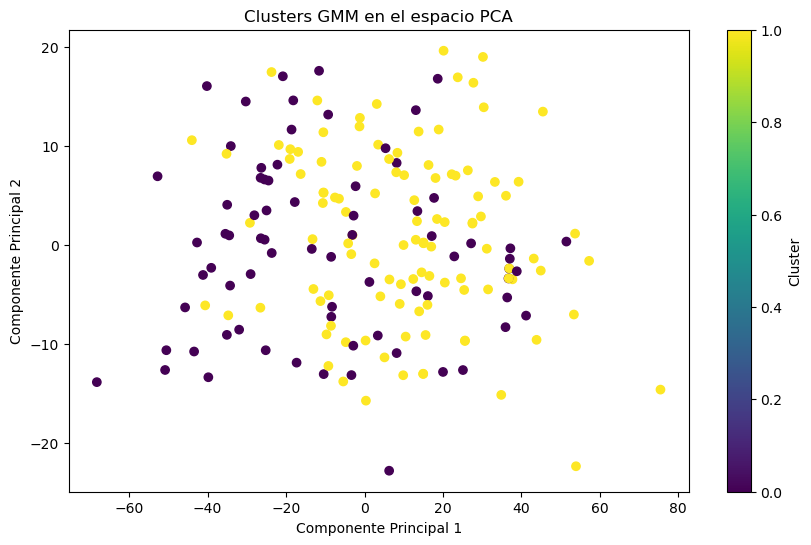

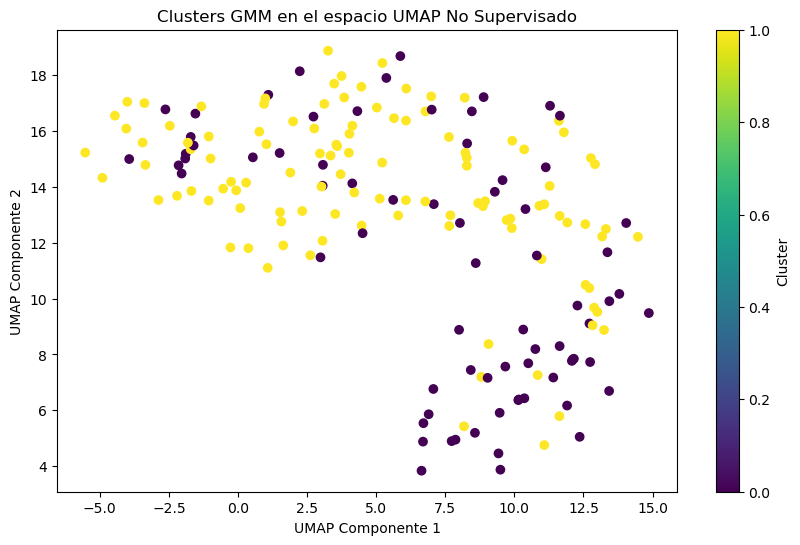

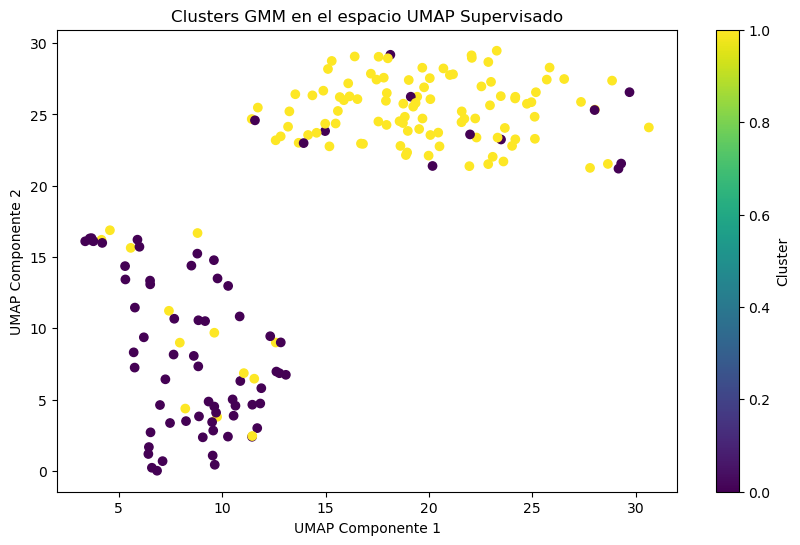

In [14]:
from sklearn.metrics import silhouette_score, accuracy_score
# Predecir y evaluar en el conjunto de prueba
y_test_pred = predict_gmm(gmms, X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

# Proyecciones en el espacio PCA y UMAP para el conjunto de prueba
X_test_pca = pca.transform(X_test)
X_test_umap_unsupervised = umap_model.transform(X_test)
X_test_umap_supervised =umap_model_supervised.transform(X_test)

# Visualizar resultados en el espacio PCA y UMAP para el conjunto de prueba
plot_projection(X_test_pca, y_test_pred, title='Clusters GMM en el espacio PCA', xlabel='Componente Principal 1', ylabel='Componente Principal 2')
plot_projection(X_test_umap_unsupervised, y_test_pred, title='Clusters GMM en el espacio UMAP No Supervisado', xlabel='UMAP Componente 1', ylabel='UMAP Componente 2')
plot_projection(X_test_umap_supervised, y_test_pred, title='Clusters GMM en el espacio UMAP Supervisado', xlabel='UMAP Componente 1', ylabel='UMAP Componente 2')
